# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2  
%autosave 10

Autosaving every 10 seconds


In [2]:
import torch, torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from PIL import Image
import random, os, sys, argparse
from pathlib import Path
from tqdm import tqdm
import pickle

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import shap

In [3]:
sys.path.insert(0,'/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/scripts/')
sys.path.insert(0,'/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/scripts/toy_models/')
from models import *
from toy_models import *

# User Hyperparams

In [101]:
model = 'vgg16' # resnet18, vgg16, densenet121, mlp
dataset = 'cifar10' # mnist,kmnist, fmnist, svhn, cifar10
add_patch_flag = False # adds a random white patch at a class-specific location
save_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/output' # directory to save output
data_dir = '/jet/home/nmurali/asc170022p/nmurali/projects/shortcut_detection_and_mitigation/data/' # directory which has data; or where you want to download data if missing

num_pd_imgs = 100 # no. of pd imgs to plot from test data
num_epochs = 5
lr = 0.1
seed = 999
num_ch = 1 # num of channels in image
num_embs = 1000 # (number of embeddings) training data size for KNN used in PD
K = 29 # k neighbours in k-NN
num_test_imgs = 50 # num of test images for plotting PD
lp_norm = 1 # for computing KNN
knn_pos_thresh = 0.5 # k-NN output above this value treated as positive
knn_neg_thresh = 0.5 # k-NN output below this value treated as negative; intermediate values treated as undefined PD samples
expt_name = f'{model}_{dataset}_{int(random.random()*100000)}' # characteristic name for the experiment (used for saving)

# Util Functions

In [102]:
# takes in a list of img paths and plots grid of images
def plot_images(img_list, rows, cols, titles=None):
    plt.figure(figsize=(7.5*cols,7.5*rows))
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        if type(img_list[0])==str:
            img = plt.imread(img_list[i])
        else:
            img = img_list[i]
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
    plt.show()

# Load Dataset

In [103]:
# Setting the seed
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [104]:
# datasets
print('==> Preparing data..')
if dataset=='mnist':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
            ])  
    trainset = torchvision.datasets.MNIST(data_dir, transform=trans, download=True)
    testset = torchvision.datasets.MNIST(data_dir, train=False, transform=trans, download=True)    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
    
elif dataset=='fmnist':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
            ])  
    trainset = torchvision.datasets.FashionMNIST(data_dir, transform=trans, download=True)
    testset = torchvision.datasets.FashionMNIST(data_dir, train=False, transform=trans, download=True)    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
    
elif dataset=='kmnist':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.ToTensor(),
            ]) 
    trainset = torchvision.datasets.KMNIST(data_dir, transform=trans, download=True)
    testset = torchvision.datasets.KMNIST(data_dir, train=False, transform=trans, download=True)    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=True, num_workers=2)
    
elif dataset=='svhn':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor(),
            ])  
    trainset = torchvision.datasets.SVHN(data_dir, split='train', transform=trans, download=True)
    testset = torchvision.datasets.SVHN(data_dir, split='test', transform=trans, download=True)
    trainset.targets = trainset.labels
    testset.targets = testset.labels
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)
    
elif dataset=='cifar10':
    trans = torchvision.transforms.Compose([
                torchvision.transforms.Resize((32,32)),
                torchvision.transforms.Grayscale(num_output_channels=1),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=0.4914,std=0.2470)
            ])  
    trainset = torchvision.datasets.CIFAR10(data_dir, transform=trans, download=True)
    testset = torchvision.datasets.CIFAR10(data_dir, train=False, transform=trans, download=True)    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=500, shuffle=False, num_workers=2)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [105]:
dir(trainset.data)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__

In [106]:
# add spurious-white patch
def add_patch(img,lab):
    mid = img.shape[0]//2
    mid_x = mid-2
    mid_y = mid+3    
    if lab==0:
        img[:4,:4] = 255
    elif lab==1:
        img[:4,-4:] = 255
    elif lab==2:
        img[-4:,:4] = 255
    elif lab==3:
        img[-4:,-4:] = 255
    elif lab==4:
        img[mid_x:mid_y,mid_x:mid_y] = 255
    elif lab==5: 
        img[:4,12:16] = 255
    elif lab==6:  
        img[-4:,12:16] = 255
    elif lab==7:
        img[12:16,:4] = 255
    elif lab==8:    
        img[12:16,-4:] = 255        
    return img

if add_patch_flag:    
    for (img,lab) in zip(trainset.data,trainset.targets):
        img = add_patch(img,lab)        
    for (img,lab) in zip(testset.data,testset.targets):
        img = add_patch(img,lab)

# Train Model

In [107]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy

# Model
print('==> Building model..')
if model=='resnet18':
    net = ResNet18(num_channels=num_ch)
elif model=='vgg16':
    net = VGG('VGG16',num_channels=num_ch)
elif model=='densenet121':
    net = DenseNet121()
elif model=='mlp':
    net = nn.Sequential(torch.nn.Linear(1024, 10))
net = net.to(device)
    
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        if model=='mlp':
            outputs = net(inputs.reshape((inputs.shape[0],-1)))
        else:
            outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            if model=='mlp':
                outputs = net(inputs.reshape((inputs.shape[0],-1)))
            else:
                outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                 % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        torch.save(state, os.path.join(save_dir,f'{expt_name}.pt'))
        best_acc = acc


for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

==> Building model..

Epoch: 0


100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


99 100 Loss: 3.113 | Acc: 10.396% (5198/50000)


100%|██████████| 20/20 [00:01<00:00, 19.27it/s]


19 20 Loss: 2.324 | Acc: 9.970% (997/10000)
Saving..

Epoch: 1


100%|██████████| 100/100 [00:09<00:00, 10.06it/s]


99 100 Loss: 2.339 | Acc: 10.016% (5008/50000)


100%|██████████| 20/20 [00:01<00:00, 17.90it/s]


19 20 Loss: 2.306 | Acc: 10.000% (1000/10000)
Saving..

Epoch: 2


100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


99 100 Loss: 2.321 | Acc: 10.188% (5094/50000)


100%|██████████| 20/20 [00:01<00:00, 17.30it/s]


19 20 Loss: 2.314 | Acc: 10.210% (1021/10000)
Saving..

Epoch: 3


100%|██████████| 100/100 [00:10<00:00,  9.91it/s]


99 100 Loss: 2.310 | Acc: 10.906% (5453/50000)


100%|██████████| 20/20 [00:01<00:00, 18.14it/s]


19 20 Loss: 2.296 | Acc: 11.330% (1133/10000)
Saving..

Epoch: 4


100%|██████████| 100/100 [00:09<00:00, 10.01it/s]


99 100 Loss: 2.248 | Acc: 14.646% (7323/50000)


100%|██████████| 20/20 [00:01<00:00, 18.55it/s]

19 20 Loss: 2.098 | Acc: 18.220% (1822/10000)
Saving..


# Obtain Train (subset) embeddings

In [108]:
## code for loading checkpoint [in case you want to load a different pre-trained model]
# expt_name = 'vgg16_cifar10_29954'
# if model=='resnet18':
#     net = nn.DataParallel(ResNet18(num_channels=num_ch))
# elif model=='vgg16':
#     net = nn.DataParallel(VGG('VGG16',num_channels=num_ch))
# net.load_state_dict(torch.load(os.path.join(save_dir,f'{expt_name}.pt'))['net'])
# net.eval()

In [109]:
# add hooks to intermediate layers to collect feature embeddings
def add_resnet18_hooks(net, hook):
    net.module.bn1.register_forward_hook(hook)
    
    net.module.layer1[0].conv1.register_forward_hook(hook)
    net.module.layer1[0].conv2.register_forward_hook(hook)
    
    net.module.layer1[1].conv1.register_forward_hook(hook)
    net.module.layer1[1].conv2.register_forward_hook(hook)

    net.module.layer2[0].conv1.register_forward_hook(hook)
    net.module.layer2[0].conv2.register_forward_hook(hook)
    
    net.module.layer2[1].conv1.register_forward_hook(hook)
    net.module.layer2[1].conv2.register_forward_hook(hook)
    
    net.module.layer3[0].conv1.register_forward_hook(hook)
    net.module.layer3[0].conv2.register_forward_hook(hook)
    
    net.module.layer3[1].conv1.register_forward_hook(hook)
    net.module.layer3[1].conv2.register_forward_hook(hook)
    
    net.module.layer4[0].conv1.register_forward_hook(hook)
    net.module.layer4[0].conv2.register_forward_hook(hook)
    
    net.module.layer4[1].conv1.register_forward_hook(hook)
    net.module.layer4[1].conv2.register_forward_hook(hook)
        
    return net

def add_vgg16_hooks(net, hook):
    net.module.features[0].register_forward_hook(hook)
    net.module.features[3].register_forward_hook(hook)
    net.module.features[7].register_forward_hook(hook)
    net.module.features[10].register_forward_hook(hook)
    net.module.features[14].register_forward_hook(hook)
    net.module.features[17].register_forward_hook(hook)
    net.module.features[20].register_forward_hook(hook)
    net.module.features[24].register_forward_hook(hook)
    net.module.features[27].register_forward_hook(hook)
    net.module.features[30].register_forward_hook(hook)
    net.module.features[34].register_forward_hook(hook)
    net.module.features[37].register_forward_hook(hook)
    net.module.features[40].register_forward_hook(hook)        
    return net

def add_densenet121_hooks(net, hook):
    
    for idx,layer in enumerate(net.module.dense1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(net.module.dense4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return net

In [110]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out): # the hook function used to collect features at intermediate layers
    out = torch.nn.functional.interpolate(out,(8,8)) # reduce dimensions for easy PD computation
    feature_maps.append(torch.reshape(out, (out.shape[0],-1)))

if model=='resnet18':
    net = add_resnet18_hooks(net, hook_feat_map)
elif model=='vgg16':
    net = add_vgg16_hooks(net, hook_feat_map)
elif model=='densenet121':
    net = add_densenet121_hooks(net, hook_feat_map)

In [111]:
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')


In [112]:
labs = torch.tensor(trainset.targets)
perm = torch.randperm(labs.size(0))
inds = perm[:num_embs]
labs = labs[inds]
samples = torch.tensor(trainset.data)[inds]

if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs) 
elif dataset=='cifar10':
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img.permute(2,0,1)))))
    samples_resized = samples_resized.unsqueeze(1)
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs)  
elif dataset=='svhn':
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    samples_resized = samples_resized.unsqueeze(1)
    train_subset = torch.utils.data.TensorDataset(samples_resized,labs) 
else:
    train_subset = torch.utils.data.TensorDataset(samples,labs)
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)

In [113]:
img.shape

torch.Size([32, 32, 3])

In [114]:
samples_resized.shape

torch.Size([1000, 1, 32, 32])

In [115]:
# code for saving pkl file of layer embeddings
save_path = os.path.join(save_dir,f'{expt_name}.pkl')
trainloader2 = torch.utils.data.DataLoader(train_subset, batch_size=30000, shuffle=True, num_workers=2)

handle = open(save_path, "wb")

with torch.no_grad():
    net.eval()
    for b_idx,batch in enumerate(tqdm(trainloader2)):        
        # print GPU memory
        print_memory_profile('Initial')
        
        if dataset=='mnist'  or dataset=='kmnist' or dataset=='fmnist':
            imgs = batch[0].unsqueeze(1).to('cuda')
        elif dataset=='svhn' or dataset=='cifar10':
            imgs = batch[0].to('cuda')
        else:
            imgs = batch[0].permute(0,3,1,2).to('cuda')
        labels = batch[1]
        
        feature_maps = []
        out = net(imgs.float())
        
        info_dict = {'batch_idx':b_idx,'num_batches':len(trainloader2),'feats':feature_maps,'labels':labels}
        pickle.dump(info_dict, handle)  
        
        # print GPU memory
        print_memory_profile('After processing Batch')
        
        # free up GPU memory
        del feature_maps, info_dict
        torch.cuda.empty_cache()     
        
        # print GPU memory
        print_memory_profile('After freeing GPU memory')
        
handle.close()
        

  0%|          | 0/1 [00:00<?, ?it/s]

Initial
15.7396240234375 5.884765625 0.4283909797668457




100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

After processing Batch
15.7396240234375 5.884765625 1.4355082511901855


After freeing GPU memory
15.7396240234375 2.41015625 0.42842817306518555




# Compute PD

In [116]:
# compute_pd.py

def compute_pred_depth(arr):
    last = arr[-1]

    p_depth = 1
    for i in range(len(arr)-1):
        ele = arr[-1-(i+1)]
        if ele!=last:
            p_depth = (len(arr)-(i+1)) + 1
            break
    
    return p_depth

In [117]:
labs = torch.tensor(testset.targets)
perm = torch.randperm(labs.size(0))
inds = perm[:num_test_imgs]
labs = labs[inds]
samples = torch.tensor(testset.data)[inds]

if dataset=='mnist' or dataset=='kmnist' or dataset=='fmnist':
    
    samples_resized = torch.empty((0,32,32))
    T = transforms.ToPILImage()
    for img in samples:
        samples_resized = torch.cat((samples_resized,trans(T(img))))
    test_subset = torch.utils.data.TensorDataset(samples_resized,labs)
else:
    test_subset = torch.utils.data.TensorDataset(samples,labs)
testloader2 = torch.utils.data.DataLoader(test_subset, batch_size=128, shuffle=True, num_workers=2)

In [118]:
# ===================== Storing Batch Statistics =====================

batch_info = {}
train_embs_pkl_path = os.path.join(save_dir,f'{expt_name}.pkl')
ckpt_path = os.path.join(save_dir,f'{expt_name}.pt')
batch_info['readme'] = f'---- K={K} ---- ckpt_path={ckpt_path} ---- pkl_path={train_embs_pkl_path} ----'
batch_info['imgs'] = [] # test images
batch_info['preds'] = [] # corresponding model predictions
batch_info['pred_probs'] = [] # corresponding model predictions
batch_info['labels'] = [] # labels of the test images
batch_info['pd'] = [] # corresponding prediction depths
batch_info['layers_knn_prob'] = [] # for each test image we have a list of knn means for every layer
batch_info['layers_knn_mode'] = [] # for each test image we have a list of knn mode for every layer

print_memory_profile('Initial')

Initial
15.7396240234375 2.41015625 0.42842817306518555




In [119]:
# loop over test images
invalid_counter = 0 # for invalid predictions (last layer mode != model output)
for test_id, (img,lab) in enumerate(tqdm(testset)):
    if test_id==num_pd_imgs:
        break
    img = img.permute([1,2,0])
    batch_info['imgs'].append(img)
    with torch.no_grad():
        to_pil_trans = transforms.ToPILImage()
        img = to_pil_trans(img.permute(2,0,1).to('cuda'))
        img = trans(img).unsqueeze(0)
        lab = int(lab)
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)
        feature_maps = []
        out = net(img)
        print(f'OUT = {out}')
        print(f'Model output: {out.max()}')
        batch_info['preds'].append(int(out.argmax()))
        batch_info['pred_probs'].append(float(torch.nn.functional.softmax(out).max()))
        batch_info['labels'].append(lab)

        print_memory_profile('Model forward pass')
        with open(train_embs_pkl_path, 'rb') as handle:            
            info_dict = pickle.load(handle)
            print_memory_profile('Pickle load')

            # loop over layers in densenet, and compute KNN for this test image
            knn_preds_mode = []  # layer-wise final KNN classification preds   
            knn_preds_prob = []
            for layer_id,feat in tqdm(enumerate(feature_maps)):
                X_i = feat.unsqueeze(1)  # test set
                X_j = info_dict['feats'][layer_id].unsqueeze(0)  # train set
                if lp_norm==2:
                    D_ij = ((X_i - X_j) ** 2).sum(-1)  # (feats_dimensionality, num_imgs) symbolic matrix of squared L2 distances
                elif lp_norm==1:
                    D_ij = (abs(X_i - X_j)).sum(-1)  # (feats_dimensionality, num_imgs) symbolic matrix of squared L2 distances
                else:
                    raise('Invalid lp_norm in arguments!')

                ind_knn = torch.topk(-D_ij,K,dim=1)  # Samples <-> Dataset, (N_test, K)
                lab_knn = info_dict['labels'][ind_knn[1]]  # (N_test, K) array of integers in [0,9]
                mode = int(lab_knn.squeeze().mode()[0])
                knn_preds_mode.append(mode)
                knn_preds_prob.append(float((lab_knn==mode).float().mean()))

            print_memory_profile('Pickle batch processed')

            # free GPU memory
            del info_dict
            torch.cuda.empty_cache()
            print_memory_profile('After GPU memory freed') 

            print('Test Image: %d' %(test_id))
            print(f'knn_preds_mode: {knn_preds_mode}')
            print(f'knn_preds_prob: {knn_preds_prob}')
            print(f'label: {lab}')
            print(f'pred: {int(out.argmax())}')
            print('\n')
            batch_info['layers_knn_prob'].append(knn_preds_prob)
            batch_info['layers_knn_mode'].append(knn_preds_mode)
            if int(out.argmax())==knn_preds_mode[-1]: # PD accurate
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
            else: # PD inaccurate, KNN pred doesn't match model pred
                print('Invalid datapoint: last_layer_mode != model_output')
                invalid_counter += 1
                
                if knn_pos_thresh==0.5 and knn_neg_thresh==0.5:
                    batch_info['pd'].append(compute_pred_depth(knn_preds_mode))
                else:
                    raise('Code not ready yet! Compute pred arr function also has to be updated!')
print(f'Invalid Counts Ratio: {invalid_counter}/{num_test_imgs}')

  0%|          | 0/10000 [00:00<?, ?it/s]

OUT = tensor([[ 0.3306,  0.6014, -0.3391, -0.3274, -0.7170, -0.1331, -0.6421,  0.1581,
          0.4889,  0.5134]], device='cuda:0')
Model output: 0.6013842225074768
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.87it/s]
  0%|          | 1/10000 [00:00<1:27:05,  1.91it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 0
knn_preds_mode: [8, 8, 1, 9, 9, 9, 9, 9, 0, 9, 9, 1, 1]
knn_preds_prob: [0.4137931168079376, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.3103448152542114, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928]
label: 3
pred: 1


OUT = tensor([[ 0.9215,  1.1260, -0.4037, -0.6976, -0.9592, -0.5497, -1.0339, -0.5138,
          1.3468,  0.5732]], device='cuda:0')
Model output: 1.3467917442321777
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.59it/s]
  0%|          | 2/10000 [00:01<1:28:44,  1.88it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 1
knn_preds_mode: [8, 8, 8, 8, 8, 7, 7, 7, 8, 8, 8, 8, 1]
knn_preds_prob: [0.4137931168079376, 0.24137930572032928, 0.24137930572032928, 0.3448275923728943, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.3103448152542114, 0.37931033968925476, 0.3448275923728943, 0.3103448152542114, 0.27586206793785095]
label: 8
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.1001,  1.2352, -0.3587, -0.7578, -0.9709, -0.6962, -1.2204, -0.7023,
          1.4877,  0.5435]], device='cuda:0')
Model output: 1.48770272731781
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.90it/s]
  0%|          | 3/10000 [00:01<1:27:36,  1.90it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 2
knn_preds_mode: [0, 0, 1, 0, 0, 0, 0, 0, 8, 8, 1, 1, 1]
knn_preds_prob: [0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095]
label: 8
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2573, -0.2323,  0.1757,  0.2483,  0.1131,  0.2316,  0.1811,  0.2236,
         -0.5138, -0.2094]], device='cuda:0')
Model output: 0.24834701418876648
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 815.94it/s]
  0%|          | 4/10000 [00:02<1:26:52,  1.92it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 3
knn_preds_mode: [0, 0, 0, 0, 0, 3, 5, 5, 3, 3, 9, 3, 3]
knn_preds_prob: [0.2068965584039688, 0.24137930572032928, 0.4137931168079376, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.3103448152542114, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.17241379618644714, 0.2068965584039688]
label: 0
pred: 3


OUT = tensor([[-0.2290, -0.1547,  0.1389,  0.2138,  0.0492,  0.2109,  0.1125,  0.2327,
         -0.4705, -0.1543]], device='cuda:0')
Model output: 0.23270386457443237
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.09it/s]
  0%|          | 5/10000 [00:02<1:26:38,  1.92it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 4
knn_preds_mode: [4, 6, 1, 1, 2, 7, 7, 3, 7, 7, 0, 7, 7]
knn_preds_prob: [0.3448275923728943, 0.48275861144065857, 0.27586206793785095, 0.2068965584039688, 0.17241379618644714, 0.3448275923728943, 0.3103448152542114, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714]
label: 6
pred: 7


OUT = tensor([[ 0.8114,  1.0601, -0.4271, -0.6599, -0.9515, -0.4612, -0.9306, -0.3765,
          1.2434,  0.5777]], device='cuda:0')
Model output: 1.243409276008606
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.57it/s]
  0%|          | 6/10000 [00:03<1:26:29,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 5
knn_preds_mode: [4, 4, 1, 1, 1, 1, 7, 1, 1, 1, 1, 8, 9]
knn_preds_prob: [0.27586206793785095, 0.2068965584039688, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928]
label: 6
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3574,  0.6196, -0.3945, -0.3028, -0.8051, -0.1190, -0.7323,  0.2096,
          0.4449,  0.6127]], device='cuda:0')
Model output: 0.6196104288101196
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 813.40it/s]
  0%|          | 7/10000 [00:03<1:26:24,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 6
knn_preds_mode: [8, 3, 8, 8, 8, 9, 8, 1, 0, 1, 1, 1, 7]
knn_preds_prob: [0.3103448152542114, 0.17241379618644714, 0.27586206793785095, 0.27586206793785095, 0.3103448152542114, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.13793103396892548, 0.2068965584039688, 0.17241379618644714, 0.13793103396892548, 0.2068965584039688]
label: 1
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2500, -0.1813,  0.1585,  0.2285,  0.0812,  0.2213,  0.1444,  0.2342,
         -0.4977, -0.1866]], device='cuda:0')
Model output: 0.2341766655445099
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.26it/s]
  0%|          | 8/10000 [00:04<1:26:12,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 7
knn_preds_mode: [4, 4, 1, 7, 3, 7, 7, 3, 0, 8, 0, 0, 0]
knn_preds_prob: [0.37931033968925476, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688]
label: 6
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3313,  0.6166, -0.3325, -0.3411, -0.7104, -0.1418, -0.6331,  0.1447,
          0.5156,  0.4902]], device='cuda:0')
Model output: 0.6165563464164734
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.13it/s]
  0%|          | 9/10000 [00:04<1:26:09,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 8
knn_preds_mode: [0, 1, 1, 1, 1, 7, 0, 7, 0, 0, 9, 9, 1]
knn_preds_prob: [0.24137930572032928, 0.24137930572032928, 0.3103448152542114, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.3103448152542114, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.3448275923728943, 0.24137930572032928]
label: 3
pred: 1


OUT = tensor([[ 0.5967,  0.8580, -0.4304, -0.5817, -0.8828, -0.3472, -0.7635, -0.0473,
          0.9740,  0.5709]], device='cuda:0')
Model output: 0.9739507436752319
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 798.08it/s]
  0%|          | 10/10000 [00:05<1:25:57,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 9
knn_preds_mode: [4, 0, 9, 1, 1, 6, 7, 1, 9, 9, 9, 9, 0]
knn_preds_prob: [0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.17241379618644714, 0.37931033968925476, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.4137931168079376, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688]
label: 1
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4815,  0.6975, -0.4652, -0.3836, -0.9121, -0.1966, -0.8207,  0.1121,
          0.6402,  0.7215]], device='cuda:0')
Model output: 0.7214798927307129
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.90it/s]
  0%|          | 11/10000 [00:05<1:25:58,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 10
knn_preds_mode: [7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 0, 1]
knn_preds_prob: [0.17241379618644714, 0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.3103448152542114, 0.27586206793785095, 0.3103448152542114, 0.3448275923728943, 0.3448275923728943, 0.3448275923728943, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928]
label: 0
pred: 9


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3670,  0.6420, -0.3726, -0.3494, -0.7720, -0.1469, -0.6979,  0.1613,
          0.5322,  0.5580]], device='cuda:0')
Model output: 0.6419548988342285
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.94it/s]
  0%|          | 12/10000 [00:06<1:25:54,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 11
knn_preds_mode: [4, 8, 9, 9, 9, 0, 0, 0, 7, 9, 9, 9, 1]
knn_preds_prob: [0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928]
label: 9
pred: 1


OUT = tensor([[ 0.0139,  0.1720, -0.0906,  0.0194, -0.3264,  0.0858, -0.2577,  0.2340,
         -0.1270,  0.1878]], device='cuda:0')
Model output: 0.23399434983730316
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 806.06it/s]
  0%|          | 13/10000 [00:06<1:25:56,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 12
knn_preds_mode: [2, 2, 1, 8, 8, 8, 8, 5, 5, 8, 7, 7, 1]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714]
label: 5
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.1284,  0.3876, -0.1977, -0.1559, -0.4909, -0.0091, -0.4279,  0.2474,
          0.1486,  0.2950]], device='cuda:0')
Model output: 0.38755908608436584
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.46it/s]
  0%|          | 14/10000 [00:07<1:25:57,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 13
knn_preds_mode: [4, 6, 1, 6, 3, 7, 7, 7, 1, 1, 1, 1, 1]
knn_preds_prob: [0.3448275923728943, 0.3448275923728943, 0.2068965584039688, 0.17241379618644714, 0.13793103396892548, 0.17241379618644714, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928]
label: 7
pred: 1


OUT = tensor([[ 0.9349,  1.1519, -0.4769, -0.7214, -1.0483, -0.5273, -1.0624, -0.4394,
          1.3777,  0.6598]], device='cuda:0')
Model output: 1.3777447938919067
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.10it/s]
  0%|          | 15/10000 [00:07<1:25:55,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 14
knn_preds_mode: [4, 4, 1, 1, 9, 7, 7, 7, 0, 0, 8, 8, 8]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.37931033968925476, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.3103448152542114, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095]
label: 9
pred: 8


OUT = tensor([[ 0.2417,  0.5287, -0.2736, -0.2722, -0.6148, -0.0908, -0.5462,  0.1918,
          0.3691,  0.4015]], device='cuda:0')
Model output: 0.5286567807197571
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 797.90it/s]
  0%|          | 16/10000 [00:08<1:25:57,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 15
knn_preds_mode: [4, 0, 1, 1, 0, 7, 7, 7, 1, 1, 1, 1, 9]
knn_preds_prob: [0.27586206793785095, 0.17241379618644714, 0.24137930572032928, 0.17241379618644714, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095]
label: 8
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2015,  0.4826, -0.2463, -0.2356, -0.5699, -0.0648, -0.5035,  0.2109,
          0.2981,  0.3621]], device='cuda:0')
Model output: 0.4825690686702728
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 799.15it/s]
  0%|          | 17/10000 [00:08<1:25:55,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 16
knn_preds_mode: [4, 6, 1, 3, 8, 2, 7, 2, 0, 1, 1, 1, 9]
knn_preds_prob: [0.37931033968925476, 0.4482758641242981, 0.3103448152542114, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.3103448152542114, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095]
label: 5
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.5825, -0.6499,  0.4919,  0.4771,  0.6181,  0.4010,  0.6842,  0.2290,
         -0.9371, -0.7111]], device='cuda:0')
Model output: 0.6841683983802795
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 799.44it/s]
  0%|          | 18/10000 [00:09<1:25:56,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 17
knn_preds_mode: [4, 6, 1, 1, 6, 4, 7, 5, 4, 4, 2, 4, 5]
knn_preds_prob: [0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.13793103396892548, 0.3103448152542114, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.3103448152542114, 0.24137930572032928, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2280,  0.4471, -0.2906, -0.1578, -0.6478, -0.0309, -0.5735,  0.2320,
          0.1930,  0.4818]], device='cuda:0')
Model output: 0.48181024193763733
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 813.20it/s]
  0%|          | 19/10000 [00:09<1:25:54,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 18
knn_preds_mode: [8, 8, 8, 9, 9, 9, 9, 9, 9, 1, 1, 1, 1]
knn_preds_prob: [0.4482758641242981, 0.4482758641242981, 0.3448275923728943, 0.27586206793785095, 0.3103448152542114, 0.37931033968925476, 0.37931033968925476, 0.4482758641242981, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688]
label: 8
pred: 9


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.0550,  1.2007, -0.3631, -0.7389, -0.9597, -0.6595, -1.1693, -0.6675,
          1.4486,  0.5477]], device='cuda:0')
Model output: 1.4485822916030884
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.34it/s]
  0%|          | 20/10000 [00:10<1:25:52,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 19
knn_preds_mode: [0, 0, 9, 8, 1, 8, 0, 0, 8, 8, 1, 1, 1]
knn_preds_prob: [0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.2068965584039688, 0.3448275923728943, 0.3448275923728943, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095]
label: 6
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5565,  0.8313, -0.4479, -0.5367, -0.9101, -0.3011, -0.7848,  0.0177,
          0.8912,  0.6262]], device='cuda:0')
Model output: 0.8911941051483154
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 806.97it/s]
  0%|          | 21/10000 [00:10<1:25:49,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 20
knn_preds_mode: [4, 8, 1, 8, 9, 9, 0, 5, 7, 0, 0, 8, 8]
knn_preds_prob: [0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.3103448152542114, 0.2068965584039688, 0.24137930572032928, 0.27586206793785095]
label: 7
pred: 8


OUT = tensor([[-0.0483,  0.0683, -0.0308,  0.0741, -0.2214,  0.1164, -0.1512,  0.2338,
         -0.2120,  0.0924]], device='cuda:0')
Model output: 0.23384921252727509
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.64it/s]
  0%|          | 22/10000 [00:11<1:25:52,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 21
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 5]
knn_preds_prob: [0.48275861144065857, 0.4137931168079376, 0.3448275923728943, 0.3448275923728943, 0.3448275923728943, 0.3448275923728943, 0.3103448152542114, 0.3103448152542114, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.27586206793785095]
label: 0
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6891, -0.8255,  0.6108,  0.5631,  0.8071,  0.4675,  0.8810,  0.2122,
         -1.0820, -0.9005]], device='cuda:0')
Model output: 0.8810392618179321
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 806.00it/s]
  0%|          | 23/10000 [00:11<1:25:43,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 22
knn_preds_mode: [4, 6, 6, 3, 4, 7, 7, 3, 2, 3, 3, 3, 4]
knn_preds_prob: [0.2068965584039688, 0.37931033968925476, 0.3448275923728943, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.3103448152542114, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688]
label: 4
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5624,  0.8397, -0.4465, -0.5451, -0.9071, -0.3090, -0.7777,  0.0158,
          0.9050,  0.6085]], device='cuda:0')
Model output: 0.9050315618515015
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.55it/s]
  0%|          | 24/10000 [00:12<1:25:48,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 23
knn_preds_mode: [4, 7, 1, 1, 0, 0, 0, 8, 0, 0, 0, 8, 8]
knn_preds_prob: [0.3103448152542114, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.17241379618644714, 0.17241379618644714, 0.27586206793785095, 0.3103448152542114, 0.27586206793785095, 0.27586206793785095, 0.3103448152542114]
label: 9
pred: 8


OUT = tensor([[-0.4523, -0.4609,  0.3581,  0.3781,  0.4027,  0.3288,  0.4669,  0.2331,
         -0.7648, -0.4966]], device='cuda:0')
Model output: 0.46688640117645264
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.51it/s]
  0%|          | 25/10000 [00:12<1:26:07,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 24
knn_preds_mode: [0, 2, 1, 3, 4, 4, 5, 3, 3, 5, 5, 5, 5]
knn_preds_prob: [0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2640, -0.2010,  0.1723,  0.2391,  0.1033,  0.2290,  0.1662,  0.2338,
         -0.5168, -0.2062]], device='cuda:0')
Model output: 0.23907774686813354
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 799.22it/s]
  0%|          | 26/10000 [00:13<1:26:02,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 25
knn_preds_mode: [0, 0, 1, 1, 3, 3, 3, 3, 3, 7, 0, 7, 0]
knn_preds_prob: [0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928]
label: 2
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0156,  0.1599, -0.0665,  0.0197, -0.2870,  0.0927, -0.2231,  0.2524,
         -0.1435,  0.1383]], device='cuda:0')
Model output: 0.2523791193962097
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 794.82it/s]
  0%|          | 27/10000 [00:13<1:25:54,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 26
knn_preds_mode: [6, 4, 7, 1, 7, 5, 7, 7, 3, 0, 3, 3, 1]
knn_preds_prob: [0.27586206793785095, 0.17241379618644714, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 4
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.9946,  1.1818, -0.4519, -0.7340, -1.0391, -0.5822, -1.1155, -0.5265,
          1.4249,  0.6435]], device='cuda:0')
Model output: 1.4248934984207153
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 806.86it/s]
  0%|          | 28/10000 [00:14<1:25:50,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 27
knn_preds_mode: [8, 9, 9, 8, 9, 9, 8, 7, 9, 8, 8, 1, 1]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.3103448152542114, 0.27586206793785095, 0.27586206793785095]
label: 0
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.0022,  0.1992, -0.0850, -0.0091, -0.3158,  0.0785, -0.2535,  0.2611,
         -0.1011,  0.1540]], device='cuda:0')
Model output: 0.2610735297203064
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.16it/s]
  0%|          | 29/10000 [00:15<1:26:07,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 28
knn_preds_mode: [4, 0, 1, 1, 2, 5, 5, 7, 7, 0, 1, 1, 7]
knn_preds_prob: [0.3448275923728943, 0.3448275923728943, 0.3448275923728943, 0.17241379618644714, 0.13793103396892548, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714]
label: 9
pred: 7


OUT = tensor([[ 0.0764,  0.3038, -0.1547, -0.0802, -0.4258,  0.0349, -0.3636,  0.2622,
          0.0214,  0.2483]], device='cuda:0')
Model output: 0.3038389980792999
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.00it/s]
  0%|          | 30/10000 [00:15<1:26:01,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 29
knn_preds_mode: [0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 7]
knn_preds_prob: [0.3103448152542114, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714]
label: 6
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.5940, -0.6697,  0.5044,  0.4874,  0.6391,  0.4080,  0.7055,  0.2273,
         -0.9530, -0.7312]], device='cuda:0')
Model output: 0.7055493593215942
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 798.69it/s]
  0%|          | 31/10000 [00:16<1:25:57,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 30
knn_preds_mode: [0, 0, 1, 3, 3, 5, 5, 7, 3, 3, 7, 5, 2]
knn_preds_prob: [0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7207,  0.9723, -0.5747, -0.6369, -1.1195, -0.3750, -0.9741, -0.0075,
          1.0926,  0.8178]], device='cuda:0')
Model output: 1.0926244258880615
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 805.81it/s]
  0%|          | 32/10000 [00:16<1:26:07,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 31
knn_preds_mode: [0, 9, 9, 9, 9, 9, 9, 8, 8, 8, 0, 8, 8]
knn_preds_prob: [0.2068965584039688, 0.24137930572032928, 0.4137931168079376, 0.3448275923728943, 0.4137931168079376, 0.37931033968925476, 0.3448275923728943, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.27586206793785095, 0.3103448152542114, 0.3448275923728943]
label: 5
pred: 8


OUT = tensor([[ 0.6663,  0.9285, -0.4837, -0.6221, -0.9712, -0.3791, -0.8495, -0.0388,
          1.0569,  0.6326]], device='cuda:0')
Model output: 1.0569361448287964
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.07it/s]
  0%|          | 33/10000 [00:17<1:26:01,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 32
knn_preds_mode: [4, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 1, 0]
knn_preds_prob: [0.24137930572032928, 0.37931033968925476, 0.24137930572032928, 0.27586206793785095, 0.17241379618644714, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.37931033968925476, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688]
label: 4
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6885, -0.8223,  0.6086,  0.5626,  0.8046,  0.4661,  0.8776,  0.2143,
         -1.0807, -0.8972]], device='cuda:0')
Model output: 0.8776025772094727
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.83it/s]
  0%|          | 34/10000 [00:17<1:26:02,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 33
knn_preds_mode: [4, 6, 1, 3, 6, 4, 5, 3, 5, 4, 6, 6, 6]
knn_preds_prob: [0.27586206793785095, 0.17241379618644714, 0.17241379618644714, 0.24137930572032928, 0.4137931168079376, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.3103448152542114, 0.3103448152542114]
label: 5
pred: 6


OUT = tensor([[ 1.3319,  1.3723, -0.2692, -0.8427, -0.9618, -0.8838, -1.4563, -0.9586,
          1.6582,  0.4639]], device='cuda:0')
Model output: 1.6582359075546265
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 792.00it/s]
  0%|          | 35/10000 [00:18<1:26:14,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 34
knn_preds_mode: [2, 8, 1, 0, 7, 7, 7, 1, 8, 8, 8, 1, 1]
knn_preds_prob: [0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.3103448152542114, 0.17241379618644714, 0.3103448152542114, 0.3448275923728943, 0.3448275923728943, 0.3448275923728943, 0.3448275923728943]
label: 9
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.1708,  0.4418, -0.2268, -0.2013, -0.5399, -0.0375, -0.4743,  0.2301,
          0.2331,  0.3346]], device='cuda:0')
Model output: 0.4418487846851349
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 798.30it/s]
  0%|          | 36/10000 [00:18<1:26:10,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 35
knn_preds_mode: [2, 0, 1, 1, 3, 5, 7, 7, 0, 0, 1, 9, 7]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.24137930572032928, 0.3103448152542114, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 2
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.1281,  0.3654, -0.2001, -0.1200, -0.4993,  0.0090, -0.4361,  0.2566,
          0.0968,  0.3143]], device='cuda:0')
Model output: 0.36536404490470886
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 806.97it/s]
  0%|          | 37/10000 [00:19<1:26:01,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 36
knn_preds_mode: [0, 0, 0, 0, 7, 7, 0, 5, 7, 0, 7, 7, 1]
knn_preds_prob: [0.37931033968925476, 0.27586206793785095, 0.3448275923728943, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.13793103396892548, 0.17241379618644714, 0.17241379618644714, 0.24137930572032928]
label: 4
pred: 1


OUT = tensor([[ 0.3374,  0.6165, -0.3436, -0.3343, -0.7287, -0.1335, -0.6519,  0.1610,
          0.5038,  0.5064]], device='cuda:0')
Model output: 0.6165419816970825
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.49it/s]
  0%|          | 38/10000 [00:19<1:25:58,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 37
knn_preds_mode: [4, 8, 0, 0, 8, 8, 0, 5, 7, 0, 9, 9, 1]
knn_preds_prob: [0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.17241379618644714, 0.24137930572032928, 0.17241379618644714, 0.13793103396892548, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928]
label: 1
pred: 1


OUT = tensor([[ 0.6507,  0.9186, -0.4377, -0.6135, -0.9194, -0.3786, -0.8136, -0.1113,
          1.0596,  0.5820]], device='cuda:0')
Model output: 1.059631109237671
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 805.25it/s]
  0%|          | 39/10000 [00:20<1:25:51,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 38
knn_preds_mode: [0, 4, 1, 1, 1, 7, 7, 7, 8, 8, 1, 1, 1]
knn_preds_prob: [0.24137930572032928, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.3103448152542114, 0.27586206793785095, 0.3103448152542114, 0.3103448152542114, 0.2068965584039688, 0.3103448152542114, 0.3103448152542114, 0.24137930572032928, 0.2068965584039688]
label: 9
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7101,  0.9770, -0.4394, -0.6384, -0.9438, -0.4092, -0.8587, -0.2025,
          1.1394,  0.5837]], device='cuda:0')
Model output: 1.139378309249878
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.71it/s]
  0%|          | 40/10000 [00:20<1:25:56,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 39
knn_preds_mode: [4, 6, 1, 1, 0, 7, 0, 7, 0, 8, 1, 9, 1]
knn_preds_prob: [0.3103448152542114, 0.27586206793785095, 0.37931033968925476, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688]
label: 5
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.3448e-01,  3.8558e-01, -2.0272e-01, -1.4438e-01, -5.0504e-01,
         -1.6526e-04, -4.4156e-01,  2.5170e-01,  1.3199e-01,  3.0834e-01]],
       device='cuda:0')
Model output: 0.3855831027030945
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.37it/s]
  0%|          | 41/10000 [00:21<1:26:02,  1.93it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 40
knn_preds_mode: [4, 6, 8, 8, 8, 0, 0, 7, 0, 0, 1, 1, 1]
knn_preds_prob: [0.37931033968925476, 0.27586206793785095, 0.3448275923728943, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714]
label: 4
pred: 1


OUT = tensor([[-0.6879, -0.8113,  0.6034,  0.5598,  0.7973,  0.4628,  0.8669,  0.2199,
         -1.0778, -0.8883]], device='cuda:0')
Model output: 0.8668810129165649
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 797.01it/s]
  0%|          | 42/10000 [00:21<1:28:02,  1.89it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 41
knn_preds_mode: [0, 0, 1, 1, 6, 4, 4, 3, 6, 6, 6, 6, 6]
knn_preds_prob: [0.2068965584039688, 0.27586206793785095, 0.3103448152542114, 0.2068965584039688, 0.3448275923728943, 0.27586206793785095, 0.3448275923728943, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.3103448152542114, 0.3103448152542114, 0.27586206793785095]
label: 6
pred: 6


OUT = tensor([[-0.6890, -0.8240,  0.6099,  0.5627,  0.8061,  0.4670,  0.8794,  0.2132,
         -1.0815, -0.8992]], device='cuda:0')
Model output: 0.8794438242912292
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 797.14it/s]
  0%|          | 43/10000 [00:22<1:27:26,  1.90it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 42
knn_preds_mode: [2, 6, 6, 3, 7, 7, 7, 7, 7, 3, 3, 4, 3]
knn_preds_prob: [0.4137931168079376, 0.4137931168079376, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.3103448152542114, 0.2068965584039688, 0.2068965584039688]
label: 5
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2629, -0.1953,  0.1701,  0.2365,  0.0995,  0.2270,  0.1620,  0.2352,
         -0.5139, -0.2036]], device='cuda:0')
Model output: 0.2365417629480362
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 813.32it/s]
  0%|          | 44/10000 [00:22<1:26:57,  1.91it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 43
knn_preds_mode: [6, 6, 1, 4, 0, 0, 0, 3, 3, 7, 0, 0, 0]
knn_preds_prob: [0.3103448152542114, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928]
label: 6
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7305,  0.9928, -0.4896, -0.6609, -1.0099, -0.4147, -0.9059, -0.1354,
          1.1573,  0.6580]], device='cuda:0')
Model output: 1.157254695892334
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.46it/s]
  0%|          | 45/10000 [00:23<1:25:40,  1.94it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 44
knn_preds_mode: [4, 4, 9, 9, 7, 7, 0, 0, 0, 0, 0, 1, 1]
knn_preds_prob: [0.24137930572032928, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.3103448152542114, 0.24137930572032928, 0.3448275923728943, 0.37931033968925476, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688]
label: 0
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4662, -0.4964,  0.3758,  0.3946,  0.4345,  0.3392,  0.5005,  0.2286,
         -0.7862, -0.5260]], device='cuda:0')
Model output: 0.5004901885986328
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.69it/s]
  0%|          | 46/10000 [00:23<1:24:42,  1.96it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 45
knn_preds_mode: [4, 4, 4, 4, 8, 4, 5, 2, 7, 3, 7, 3, 7]
knn_preds_prob: [0.4137931168079376, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.17241379618644714, 0.13793103396892548, 0.17241379618644714, 0.2068965584039688, 0.24137930572032928, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.9372,  1.1342, -0.3980, -0.7007, -0.9580, -0.5631, -1.0494, -0.5337,
          1.3597,  0.5676]], device='cuda:0')
Model output: 1.3596899509429932
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.56it/s]
  0%|          | 47/10000 [00:24<1:24:11,  1.97it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 46
knn_preds_mode: [2, 2, 1, 3, 2, 2, 0, 8, 8, 8, 8, 1, 1]
knn_preds_prob: [0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.24137930572032928, 0.3448275923728943, 0.4137931168079376, 0.37931033968925476, 0.27586206793785095, 0.27586206793785095]
label: 3
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6159, -0.7010,  0.5271,  0.5035,  0.6752,  0.4202,  0.7418,  0.2259,
         -0.9816, -0.7667]], device='cuda:0')
Model output: 0.7417595386505127
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.11it/s]
  0%|          | 48/10000 [00:24<1:23:38,  1.98it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 47
knn_preds_mode: [4, 4, 1, 3, 4, 4, 4, 2, 3, 4, 7, 7, 7]
knn_preds_prob: [0.3103448152542114, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.3103448152542114, 0.3103448152542114, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688]
label: 9
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4885, -0.5127,  0.3943,  0.4052,  0.4621,  0.3484,  0.5265,  0.2334,
         -0.8127, -0.5562]], device='cuda:0')
Model output: 0.5265282988548279
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.09it/s]
  0%|          | 49/10000 [00:25<1:23:15,  1.99it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 48
knn_preds_mode: [4, 6, 1, 4, 3, 3, 8, 5, 3, 3, 5, 5, 4]
knn_preds_prob: [0.3103448152542114, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.9075,  1.1348, -0.4698, -0.7135, -1.0326, -0.5118, -1.0361, -0.4189,
          1.3523,  0.6485]], device='cuda:0')
Model output: 1.3523101806640625
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.47it/s]
  0%|          | 50/10000 [00:25<1:23:00,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 49
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 9]
knn_preds_prob: [0.37931033968925476, 0.4137931168079376, 0.517241358757019, 0.37931033968925476, 0.24137930572032928, 0.24137930572032928, 0.3103448152542114, 0.27586206793785095, 0.24137930572032928, 0.3448275923728943, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095]
label: 6
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2073,  0.4865, -0.2515, -0.2380, -0.5788, -0.0652, -0.5121,  0.2118,
          0.3028,  0.3709]], device='cuda:0')
Model output: 0.48651114106178284
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.46it/s]
  1%|          | 51/10000 [00:26<1:22:49,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 50
knn_preds_mode: [4, 0, 1, 1, 0, 7, 7, 1, 0, 1, 1, 1, 9]
knn_preds_prob: [0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.27586206793785095, 0.24137930572032928, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095]
label: 9
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.0862,  1.2347, -0.4080, -0.7644, -1.0232, -0.6655, -1.2087, -0.6493,
          1.4947,  0.6084]], device='cuda:0')
Model output: 1.4946820735931396
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.79it/s]
  1%|          | 52/10000 [00:26<1:22:49,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 51
knn_preds_mode: [0, 0, 0, 0, 8, 8, 0, 0, 9, 8, 8, 1, 1]
knn_preds_prob: [0.3103448152542114, 0.3448275923728943, 0.4482758641242981, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.3448275923728943, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095]
label: 8
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2389,  0.4840, -0.2999, -0.1934, -0.6602, -0.0460, -0.5912,  0.2435,
          0.2421,  0.4728]], device='cuda:0')
Model output: 0.4840448796749115
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.02it/s]
  1%|          | 53/10000 [00:27<1:22:39,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 52
knn_preds_mode: [2, 0, 0, 0, 8, 8, 0, 5, 8, 1, 7, 1, 1]
knn_preds_prob: [0.24137930572032928, 0.3103448152542114, 0.48275861144065857, 0.3103448152542114, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.24137930572032928]
label: 0
pred: 1


OUT = tensor([[ 0.5044,  0.7789, -0.3957, -0.5134, -0.8194, -0.2844, -0.6959,  0.0074,
          0.8363,  0.5360]], device='cuda:0')
Model output: 0.8362805843353271
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.53it/s]
  1%|          | 54/10000 [00:27<1:22:33,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 53
knn_preds_mode: [4, 1, 1, 1, 0, 7, 0, 7, 0, 8, 8, 8, 8]
knn_preds_prob: [0.3103448152542114, 0.17241379618644714, 0.4137931168079376, 0.27586206793785095, 0.17241379618644714, 0.27586206793785095, 0.24137930572032928, 0.37931033968925476, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.3448275923728943]
label: 3
pred: 8


OUT = tensor([[ 0.4651,  0.7309, -0.4575, -0.4039, -0.9059, -0.1935, -0.8260,  0.1474,
          0.6480,  0.6940]], device='cuda:0')
Model output: 0.7309427261352539
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.53it/s]
  1%|          | 55/10000 [00:28<1:22:30,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 54
knn_preds_mode: [4, 0, 9, 9, 9, 9, 9, 7, 1, 1, 9, 1, 1]
knn_preds_prob: [0.24137930572032928, 0.2068965584039688, 0.37931033968925476, 0.3448275923728943, 0.3103448152542114, 0.3448275923728943, 0.27586206793785095, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928]
label: 8
pred: 1


OUT = tensor([[-0.3327, -0.2882,  0.2368,  0.2880,  0.2076,  0.2630,  0.2698,  0.2370,
         -0.6064, -0.3076]], device='cuda:0')
Model output: 0.28801536560058594
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 811.17it/s]
  1%|          | 56/10000 [00:28<1:22:28,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 55
knn_preds_mode: [2, 4, 4, 4, 6, 6, 6, 2, 2, 1, 0, 0, 0]
knn_preds_prob: [0.24137930572032928, 0.27586206793785095, 0.37931033968925476, 0.3103448152542114, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714]
label: 8
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1270,  0.0026,  0.0381,  0.1190, -0.1162,  0.1510, -0.0528,  0.2474,
         -0.3130, -0.0102]], device='cuda:0')
Model output: 0.24741815030574799
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 814.51it/s]
  1%|          | 57/10000 [00:29<1:22:28,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 56
knn_preds_mode: [4, 6, 1, 1, 6, 4, 4, 2, 1, 0, 0, 0, 0]
knn_preds_prob: [0.3103448152542114, 0.37931033968925476, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.3103448152542114, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928]
label: 7
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.9917,  1.1652, -0.3878, -0.7190, -0.9663, -0.6059, -1.1048, -0.5916,
          1.4039,  0.5687]], device='cuda:0')
Model output: 1.4038752317428589
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 806.53it/s]
  1%|          | 58/10000 [00:29<1:22:32,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 57
knn_preds_mode: [6, 6, 1, 1, 8, 2, 7, 1, 8, 8, 1, 1, 1]
knn_preds_prob: [0.37931033968925476, 0.3448275923728943, 0.3103448152542114, 0.2068965584039688, 0.3103448152542114, 0.13793103396892548, 0.24137930572032928, 0.2068965584039688, 0.3103448152542114, 0.3103448152542114, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095]
label: 7
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1315, -0.0122,  0.0446,  0.1304, -0.1064,  0.1571, -0.0417,  0.2398,
         -0.3275, -0.0168]], device='cuda:0')
Model output: 0.23975980281829834
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.70it/s]
  1%|          | 59/10000 [00:30<1:22:42,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 58
knn_preds_mode: [4, 0, 8, 1, 7, 5, 0, 5, 3, 0, 0, 0, 0]
knn_preds_prob: [0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.2068965584039688, 0.3103448152542114, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.2068965584039688, 0.17241379618644714, 0.27586206793785095, 0.3103448152542114, 0.3103448152542114]
label: 4
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6704, -0.7832,  0.5844,  0.5459,  0.7670,  0.4519,  0.8351,  0.2222,
         -1.0544, -0.8577]], device='cuda:0')
Model output: 0.8350756764411926
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.33it/s]
  1%|          | 60/10000 [00:30<1:22:41,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 59
knn_preds_mode: [4, 4, 1, 1, 3, 3, 5, 7, 4, 6, 6, 6, 6]
knn_preds_prob: [0.37931033968925476, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.3103448152542114, 0.24137930572032928, 0.27586206793785095]
label: 6
pred: 6


OUT = tensor([[-0.1365, -0.0338,  0.0522,  0.1448, -0.0923,  0.1642, -0.0264,  0.2305,
         -0.3448, -0.0232]], device='cuda:0')
Model output: 0.23051312565803528
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.71it/s]
  1%|          | 61/10000 [00:31<1:22:46,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 60
knn_preds_mode: [4, 0, 1, 1, 8, 0, 0, 7, 7, 8, 1, 0, 0]
knn_preds_prob: [0.3448275923728943, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.17241379618644714, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714]
label: 7
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0515,  0.0922, -0.0300,  0.0675, -0.2283,  0.1179, -0.1619,  0.2378,
         -0.2155,  0.0956]], device='cuda:0')
Model output: 0.237763911485672
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 806.64it/s]
  1%|          | 62/10000 [00:31<1:22:43,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 61
knn_preds_mode: [4, 6, 8, 1, 7, 7, 0, 3, 7, 3, 0, 3, 0]
knn_preds_prob: [0.3103448152542114, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.24137930572032928, 0.17241379618644714, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688]
label: 3
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1754, -0.0691,  0.0850,  0.1640, -0.0393,  0.1781,  0.0237,  0.2418,
         -0.3879, -0.0775]], device='cuda:0')
Model output: 0.24183040857315063
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.53it/s]
  1%|          | 63/10000 [00:32<1:22:51,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 62
knn_preds_mode: [6, 6, 1, 3, 9, 2, 5, 4, 0, 0, 0, 0, 0]
knn_preds_prob: [0.24137930572032928, 0.4137931168079376, 0.17241379618644714, 0.13793103396892548, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928]
label: 6
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5172,  0.7867, -0.3983, -0.5217, -0.8257, -0.2908, -0.6978,  0.0017,
          0.8570,  0.5294]], device='cuda:0')
Model output: 0.8569997549057007
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.28it/s]
  1%|          | 64/10000 [00:32<1:22:46,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 63
knn_preds_mode: [6, 6, 7, 7, 7, 7, 7, 3, 7, 8, 8, 8, 8]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.17241379618644714, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.3448275923728943]
label: 3
pred: 8


OUT = tensor([[ 0.3453,  0.6373, -0.3305, -0.3662, -0.7102, -0.1659, -0.6267,  0.1208,
          0.5682,  0.4712]], device='cuda:0')
Model output: 0.6372799277305603
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.22it/s]
  1%|          | 65/10000 [00:33<1:22:43,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 64
knn_preds_mode: [4, 5, 8, 8, 8, 0, 0, 3, 2, 0, 0, 9, 9]
knn_preds_prob: [0.3448275923728943, 0.13793103396892548, 0.24137930572032928, 0.24137930572032928, 0.3103448152542114, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928]
label: 6
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2733,  0.5567, -0.2982, -0.2893, -0.6581, -0.0976, -0.5862,  0.1888,
          0.4060,  0.4381]], device='cuda:0')
Model output: 0.5567417144775391
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.35it/s]
  1%|          | 66/10000 [00:33<1:22:40,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 65
knn_preds_mode: [2, 2, 1, 0, 8, 7, 0, 0, 0, 0, 9, 1, 9]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.27586206793785095, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.3103448152542114, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.27586206793785095]
label: 2
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.2022,  1.3052, -0.3558, -0.8041, -1.0075, -0.7699, -1.3310, -0.7768,
          1.5769,  0.5534]], device='cuda:0')
Model output: 1.576888084411621
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.33it/s]
  1%|          | 67/10000 [00:34<1:22:40,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 66
knn_preds_mode: [2, 6, 1, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.4137931168079376, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928]
label: 1
pred: 8


OUT = tensor([[-0.1497, -0.0815,  0.0712,  0.1711, -0.0589,  0.1782,  0.0101,  0.2167,
         -0.3748, -0.0453]], device='cuda:0')
Model output: 0.21672092378139496
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.25it/s]
  1%|          | 68/10000 [00:34<1:22:35,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 67
knn_preds_mode: [0, 0, 0, 8, 8, 5, 5, 5, 5, 8, 5, 5, 0]
knn_preds_prob: [0.37931033968925476, 0.4137931168079376, 0.4137931168079376, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 2
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6890, -0.8193,  0.6081,  0.5614,  0.8031,  0.4658,  0.8749,  0.2155,
         -1.0804, -0.8957]], device='cuda:0')
Model output: 0.8749488592147827
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.11it/s]
  1%|          | 69/10000 [00:35<1:22:32,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 68
knn_preds_mode: [0, 0, 9, 4, 6, 7, 4, 3, 4, 6, 2, 2, 6]
knn_preds_prob: [0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.17241379618644714, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928]
label: 3
pred: 6


OUT = tensor([[-0.3179, -0.3043,  0.2322,  0.2908,  0.2028,  0.2632,  0.2696,  0.2243,
         -0.5943, -0.2965]], device='cuda:0')
Model output: 0.2908197343349457
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.04it/s]
  1%|          | 70/10000 [00:35<1:22:37,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 69
knn_preds_mode: [4, 6, 0, 5, 5, 5, 5, 5, 5, 5, 9, 3, 9]
knn_preds_prob: [0.3103448152542114, 0.17241379618644714, 0.17241379618644714, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.27586206793785095, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928]
label: 7
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.3828,  0.6249, -0.4183, -0.2982, -0.8430, -0.1251, -0.7630,  0.1956,
          0.4519,  0.6613]], device='cuda:0')
Model output: 0.661288857460022
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.43it/s]
  1%|          | 71/10000 [00:36<1:22:33,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 70
knn_preds_mode: [8, 8, 8, 8, 9, 8, 8, 3, 0, 9, 8, 8, 7]
knn_preds_prob: [0.3448275923728943, 0.4137931168079376, 0.37931033968925476, 0.3448275923728943, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.17241379618644714, 0.24137930572032928, 0.3103448152542114, 0.17241379618644714, 0.2068965584039688]
label: 2
pred: 9


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0877,  0.0598,  0.0013,  0.0829, -0.1770,  0.1306, -0.1135,  0.2494,
         -0.2523,  0.0418]], device='cuda:0')
Model output: 0.2493525743484497
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.39it/s]
  1%|          | 72/10000 [00:36<1:22:31,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 71
knn_preds_mode: [2, 6, 1, 7, 7, 4, 7, 7, 0, 0, 0, 0, 0]
knn_preds_prob: [0.3448275923728943, 0.3448275923728943, 0.17241379618644714, 0.24137930572032928, 0.3448275923728943, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928]
label: 6
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2856,  0.4881, -0.3291, -0.2089, -0.6980, -0.0716, -0.6188,  0.1990,
          0.2988,  0.5319]], device='cuda:0')
Model output: 0.5318840742111206
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.19it/s]
  1%|          | 73/10000 [00:37<1:22:34,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 72
knn_preds_mode: [8, 8, 0, 0, 0, 0, 0, 8, 9, 8, 8, 9, 8]
knn_preds_prob: [0.27586206793785095, 0.3103448152542114, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714]
label: 8
pred: 9


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1826, -0.1095,  0.0987,  0.1880, -0.0151,  0.1917,  0.0514,  0.2238,
         -0.4145, -0.0905]], device='cuda:0')
Model output: 0.2238347977399826
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.18it/s]
  1%|          | 74/10000 [00:37<1:22:33,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 73
knn_preds_mode: [4, 3, 0, 0, 8, 5, 5, 5, 8, 5, 5, 7, 8]
knn_preds_prob: [0.24137930572032928, 0.27586206793785095, 0.17241379618644714, 0.3103448152542114, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714]
label: 8
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.7799,  1.0393, -0.4208, -0.6503, -0.9373, -0.4458, -0.9018, -0.3422,
          1.2154,  0.5632]], device='cuda:0')
Model output: 1.2154237031936646
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.22it/s]
  1%|          | 75/10000 [00:38<1:22:32,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 74
knn_preds_mode: [4, 4, 1, 1, 3, 2, 5, 8, 8, 8, 9, 1, 1]
knn_preds_prob: [0.3103448152542114, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.3103448152542114, 0.3448275923728943, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095]
label: 0
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0690,  0.0415, -0.0085,  0.1017, -0.1905,  0.1339, -0.1214,  0.2205,
         -0.2596,  0.0733]], device='cuda:0')
Model output: 0.22047626972198486
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.16it/s]
  1%|          | 76/10000 [00:38<1:22:41,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 75
knn_preds_mode: [0, 2, 8, 8, 8, 0, 5, 5, 7, 7, 5, 5, 5]
knn_preds_prob: [0.24137930572032928, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688]
label: 2
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0141,  0.1267, -0.0627,  0.0488, -0.2805,  0.1027, -0.2111,  0.2282,
         -0.1738,  0.1494]], device='cuda:0')
Model output: 0.2282431423664093
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 819.22it/s]
  1%|          | 77/10000 [00:39<1:22:37,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 76
knn_preds_mode: [4, 6, 8, 8, 8, 0, 5, 5, 8, 8, 5, 5, 5]
knn_preds_prob: [0.4482758641242981, 0.27586206793785095, 0.3103448152542114, 0.3103448152542114, 0.3103448152542114, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688]
label: 9
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.2614, -0.2166,  0.1748,  0.2459,  0.1085,  0.2329,  0.1737,  0.2243,
         -0.5193, -0.2058]], device='cuda:0')
Model output: 0.2458668351173401
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.92it/s]
  1%|          | 78/10000 [00:39<1:22:31,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 77
knn_preds_mode: [4, 4, 8, 8, 8, 8, 0, 3, 3, 5, 3, 7, 7]
knn_preds_prob: [0.3103448152542114, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.13793103396892548, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095]
label: 3
pred: 3


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6864, -0.8147,  0.6031,  0.5612,  0.7983,  0.4625,  0.8692,  0.2187,
         -1.0769, -0.8890]], device='cuda:0')
Model output: 0.8691825866699219
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.90it/s]
  1%|          | 79/10000 [00:40<1:22:33,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 78
knn_preds_mode: [2, 6, 6, 3, 4, 4, 4, 2, 5, 6, 2, 2, 2]
knn_preds_prob: [0.3448275923728943, 0.3448275923728943, 0.3103448152542114, 0.17241379618644714, 0.27586206793785095, 0.27586206793785095, 0.3103448152542114, 0.17241379618644714, 0.2068965584039688, 0.27586206793785095, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688]
label: 3
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2194,  0.5035, -0.2584, -0.2497, -0.5935, -0.0707, -0.5248,  0.2071,
          0.3265,  0.3776]], device='cuda:0')
Model output: 0.5034810900688171
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.74it/s]
  1%|          | 80/10000 [00:40<1:22:29,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 79
knn_preds_mode: [4, 6, 1, 1, 7, 7, 0, 3, 0, 0, 1, 1, 9]
knn_preds_prob: [0.24137930572032928, 0.27586206793785095, 0.3448275923728943, 0.24137930572032928, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.3103448152542114]
label: 8
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 1.7386,  1.6057, -0.0864, -0.9774, -0.9256, -1.2255, -1.8631, -1.4105,
          1.9214,  0.2795]], device='cuda:0')
Model output: 1.9213858842849731
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.16it/s]
  1%|          | 81/10000 [00:41<1:22:25,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 80
knn_preds_mode: [8, 8, 1, 1, 7, 7, 7, 9, 8, 8, 8, 8, 8]
knn_preds_prob: [0.24137930572032928, 0.3103448152542114, 0.3103448152542114, 0.37931033968925476, 0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.2068965584039688, 0.27586206793785095, 0.3448275923728943, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095]
label: 8
pred: 8


OUT = tensor([[ 0.8515,  1.0942, -0.4358, -0.6849, -0.9754, -0.4875, -0.9752, -0.4024,
          1.2946,  0.5941]], device='cuda:0')
Model output: 1.2945914268493652
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.87it/s]
  1%|          | 82/10000 [00:41<1:22:24,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 81
knn_preds_mode: [4, 6, 8, 8, 8, 0, 0, 7, 0, 8, 1, 9, 9]
knn_preds_prob: [0.27586206793785095, 0.2068965584039688, 0.3448275923728943, 0.37931033968925476, 0.27586206793785095, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.37931033968925476, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095]
label: 1
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1614, -0.0889,  0.0805,  0.1762, -0.0444,  0.1826,  0.0234,  0.2198,
         -0.3888, -0.0608]], device='cuda:0')
Model output: 0.21979057788848877
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.36it/s]
  1%|          | 83/10000 [00:42<1:22:22,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 82
knn_preds_mode: [2, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5]
knn_preds_prob: [0.24137930572032928, 0.24137930572032928, 0.4482758641242981, 0.3103448152542114, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688]
label: 1
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4533, -0.4811,  0.3633,  0.3861,  0.4151,  0.3325,  0.4811,  0.2283,
         -0.7697, -0.5059]], device='cuda:0')
Model output: 0.4811190366744995
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.50it/s]
  1%|          | 84/10000 [00:42<1:22:22,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 83
knn_preds_mode: [8, 2, 1, 1, 8, 5, 2, 3, 7, 5, 3, 3, 7]
knn_preds_prob: [0.24137930572032928, 0.13793103396892548, 0.27586206793785095, 0.13793103396892548, 0.2068965584039688, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 7
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0856,  0.0508,  0.0008,  0.0920, -0.1777,  0.1331, -0.1124,  0.2417,
         -0.2609,  0.0485]], device='cuda:0')
Model output: 0.2416875660419464
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.73it/s]
  1%|          | 85/10000 [00:43<1:22:22,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 84
knn_preds_mode: [4, 8, 1, 1, 1, 5, 0, 7, 7, 7, 0, 0, 0]
knn_preds_prob: [0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.4137931168079376, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928]
label: 2
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.0901,  0.3002, -0.1677, -0.0715, -0.4460,  0.0326, -0.3810,  0.2585,
          0.0185,  0.2816]], device='cuda:0')
Model output: 0.30020496249198914
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.09it/s]
  1%|          | 86/10000 [00:43<1:22:23,  2.01it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 85
knn_preds_mode: [0, 8, 9, 9, 9, 9, 7, 7, 7, 7, 7, 1, 7]
knn_preds_prob: [0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.37931033968925476, 0.3103448152542114, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928, 0.3103448152542114, 0.3103448152542114, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928]
label: 5
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.4569, -0.4628,  0.3617,  0.3799,  0.4076,  0.3302,  0.4713,  0.2338,
         -0.7698, -0.5020]], device='cuda:0')
Model output: 0.4713394045829773
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 808.13it/s]
  1%|          | 87/10000 [00:44<1:22:26,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 86
knn_preds_mode: [4, 0, 1, 1, 1, 4, 4, 4, 7, 4, 5, 5, 5]
knn_preds_prob: [0.37931033968925476, 0.13793103396892548, 0.2068965584039688, 0.27586206793785095, 0.17241379618644714, 0.24137930572032928, 0.24137930572032928, 0.27586206793785095, 0.3103448152542114, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.2068965584039688]
label: 2
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.5863,  0.7939, -0.5085, -0.4855, -0.9914, -0.2676, -0.8838,  0.0394,
          0.8319,  0.7632]], device='cuda:0')
Model output: 0.8318798542022705
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 806.53it/s]
  1%|          | 88/10000 [00:44<1:22:41,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 87
knn_preds_mode: [8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9]
knn_preds_prob: [0.4482758641242981, 0.3103448152542114, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.3103448152542114, 0.3103448152542114, 0.37931033968925476, 0.3448275923728943, 0.4137931168079376, 0.3448275923728943, 0.27586206793785095, 0.37931033968925476]
label: 7
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.1854,  0.4613, -0.2384, -0.2152, -0.5583, -0.0479, -0.4926,  0.2268,
          0.2592,  0.3497]], device='cuda:0')
Model output: 0.46125659346580505
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.03it/s]
  1%|          | 89/10000 [00:45<1:22:37,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 88
knn_preds_mode: [0, 0, 0, 3, 7, 3, 3, 7, 1, 1, 1, 1, 7]
knn_preds_prob: [0.17241379618644714, 0.17241379618644714, 0.13793103396892548, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714]
label: 8
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1619, -0.0546,  0.0731,  0.1561, -0.0588,  0.1727,  0.0052,  0.2391,
         -0.3717, -0.0588]], device='cuda:0')
Model output: 0.2391379475593567
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.97it/s]
  1%|          | 90/10000 [00:45<1:22:32,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 89
knn_preds_mode: [4, 6, 1, 6, 4, 5, 7, 7, 3, 0, 0, 0, 0]
knn_preds_prob: [0.3448275923728943, 0.48275861144065857, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.17241379618644714, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095]
label: 9
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1583, -0.0818,  0.0770,  0.1722, -0.0504,  0.1805,  0.0170,  0.2211,
         -0.3836, -0.0561]], device='cuda:0')
Model output: 0.221066415309906
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.84it/s]
  1%|          | 91/10000 [00:46<1:22:29,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 90
knn_preds_mode: [4, 4, 0, 8, 5, 5, 5, 5, 8, 5, 5, 5, 5]
knn_preds_prob: [0.3448275923728943, 0.3448275923728943, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688]
label: 0
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.1399, -0.0546,  0.0591,  0.1570, -0.0798,  0.1706, -0.0124,  0.2216,
         -0.3578, -0.0288]], device='cuda:0')
Model output: 0.22157540917396545
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.53it/s]
  1%|          | 92/10000 [00:46<1:22:28,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 91
knn_preds_mode: [4, 4, 0, 3, 3, 3, 0, 5, 5, 0, 5, 8, 5]
knn_preds_prob: [0.3103448152542114, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714, 0.13793103396892548, 0.24137930572032928, 0.2068965584039688, 0.17241379618644714]
label: 3
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.0327,  0.1292, -0.0488,  0.0418, -0.2595,  0.1052, -0.1943,  0.2448,
         -0.1771,  0.1167]], device='cuda:0')
Model output: 0.24479153752326965
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.65it/s]
  1%|          | 93/10000 [00:47<1:22:23,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 92
knn_preds_mode: [4, 0, 8, 8, 8, 5, 5, 3, 2, 0, 3, 3, 0]
knn_preds_prob: [0.24137930572032928, 0.2068965584039688, 0.4137931168079376, 0.4137931168079376, 0.37931033968925476, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.17241379618644714, 0.17241379618644714, 0.2068965584039688, 0.24137930572032928, 0.17241379618644714]
label: 8
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.8499,  1.0846, -0.4248, -0.6776, -0.9596, -0.4865, -0.9660, -0.4227,
          1.2855,  0.5848]], device='cuda:0')
Model output: 1.2854655981063843
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.95it/s]
  1%|          | 94/10000 [00:47<1:22:27,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 93
knn_preds_mode: [0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 1, 9, 9]
knn_preds_prob: [0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095]
label: 6
pred: 8


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.2237,  0.4954, -0.2707, -0.2361, -0.6106, -0.0607, -0.5439,  0.2208,
          0.3008,  0.4041]], device='cuda:0')
Model output: 0.4953592121601105
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 807.43it/s]
  1%|          | 95/10000 [00:48<1:22:23,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 94
knn_preds_mode: [2, 6, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 7]
knn_preds_prob: [0.3103448152542114, 0.3103448152542114, 0.24137930572032928, 0.24137930572032928, 0.3103448152542114, 0.27586206793785095, 0.24137930572032928, 0.17241379618644714, 0.27586206793785095, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.17241379618644714]
label: 4
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6891, -0.8235,  0.6098,  0.5626,  0.8058,  0.4670,  0.8790,  0.2134,
         -1.0816, -0.8989]], device='cuda:0')
Model output: 0.8790005445480347
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 820.16it/s]
  1%|          | 96/10000 [00:48<1:22:26,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 95
knn_preds_mode: [4, 6, 1, 6, 6, 2, 2, 3, 3, 4, 6, 6, 3]
knn_preds_prob: [0.3448275923728943, 0.3103448152542114, 0.3103448152542114, 0.17241379618644714, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.27586206793785095, 0.27586206793785095, 0.24137930572032928, 0.24137930572032928]
label: 6
pred: 6


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.4090,  0.6983, -0.3471, -0.4352, -0.7374, -0.2291, -0.6348,  0.0362,
          0.6945,  0.4866]], device='cuda:0')
Model output: 0.698303759098053
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.51it/s]
  1%|          | 97/10000 [00:49<1:22:27,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 96
knn_preds_mode: [4, 6, 1, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0]
knn_preds_prob: [0.27586206793785095, 0.3103448152542114, 0.37931033968925476, 0.3103448152542114, 0.2068965584039688, 0.13793103396892548, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.3103448152542114, 0.17241379618644714, 0.27586206793785095, 0.3103448152542114]
label: 6
pred: 1


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[-0.6876, -0.8201,  0.6068,  0.5622,  0.8027,  0.4647,  0.8752,  0.2157,
         -1.0793, -0.8948]], device='cuda:0')
Model output: 0.8752449750900269
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.90it/s]
  1%|          | 98/10000 [00:49<1:22:27,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 97
knn_preds_mode: [6, 6, 2, 2, 4, 4, 4, 6, 2, 2, 2, 6, 6]
knn_preds_prob: [0.3103448152542114, 0.4137931168079376, 0.37931033968925476, 0.3448275923728943, 0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.3448275923728943, 0.24137930572032928, 0.2068965584039688, 0.2068965584039688, 0.27586206793785095, 0.24137930572032928]
label: 0
pred: 6


OUT = tensor([[-0.0239,  0.1503, -0.0588,  0.0253, -0.2748,  0.0972, -0.2111,  0.2529,
         -0.1546,  0.1264]], device='cuda:0')
Model output: 0.25289031863212585
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 809.31it/s]
  1%|          | 99/10000 [00:50<1:22:25,  2.00it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 98
knn_preds_mode: [6, 6, 1, 1, 5, 5, 0, 7, 7, 1, 3, 3, 3]
knn_preds_prob: [0.24137930572032928, 0.24137930572032928, 0.24137930572032928, 0.17241379618644714, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688, 0.24137930572032928, 0.27586206793785095, 0.2068965584039688, 0.27586206793785095, 0.2068965584039688, 0.17241379618644714]
label: 0
pred: 7


Invalid datapoint: last_layer_mode != model_output
OUT = tensor([[ 0.1456,  0.3305, -0.2111, -0.0781, -0.5224,  0.0209, -0.4477,  0.2228,
          0.0559,  0.3710]], device='cuda:0')
Model output: 0.3709501326084137
Model forward pass
15.7396240234375 2.412109375 0.4293980598449707


Pickle load
15.7396240234375 2.412109375 1.4364781379699707





13it [00:00, 810.61it/s]
  1%|          | 100/10000 [00:50<1:23:45,  1.97it/s]

Pickle batch processed
15.7396240234375 2.412109375 1.3142857551574707


After GPU memory freed
15.7396240234375 2.41015625 0.4292759895324707


Test Image: 99
knn_preds_mode: [8, 0, 0, 0, 9, 9, 9, 5, 5, 5, 8, 8, 7]
knn_preds_prob: [0.37931033968925476, 0.24137930572032928, 0.3448275923728943, 0.27586206793785095, 0.27586206793785095, 0.27586206793785095, 0.2068965584039688, 0.17241379618644714, 0.2068965584039688, 0.2068965584039688, 0.24137930572032928, 0.24137930572032928, 0.2068965584039688]
label: 7
pred: 9


Invalid datapoint: last_layer_mode != model_output
Invalid Counts Ratio: 75/50


In [120]:
# ===================== Save results =====================

with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'wb') as handle:
    pickle.dump(batch_info, handle)

11.85


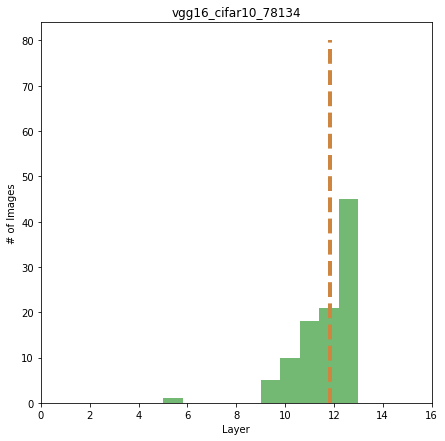

In [121]:
# plot PDs histogram
with open(os.path.join(save_dir,expt_name+'_testPDinfo.pkl'), 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
correct_preds_arr = (batch_info['preds']==batch_info['labels'])


plt.figure(figsize=(7,7))
plt.title(expt_name)
plt.ylabel('# of Images')
plt.xlabel('Layer')
if model=='resnet18':
    plt.xlim((0,18))
elif model=='vgg16':
    plt.xlim((0,16))
# plt.ylim((0,80))
plt.hist(batch_info['pd'],bins=10,color='g',alpha=0.55)
# plt.hist(batch_info['pd'][~correct_preds_arr ],bins=100,color='r',alpha=0.55)
pd_mean = np.mean(batch_info['pd'])
plt.vlines(pd_mean,0,80,color='peru',linestyle='dashed',linewidth=4)
# plt.savefig(os.path.join(save_dir,expt_name+'_PDplot.png'))
print(pd_mean)

In [122]:
os.path.join(save_dir,expt_name+'_testPDinfo.pkl')

'/jet/home/nmurali/asc170022p/nmurali/projects/misc/TMLR23_Dynamics_of_Spurious_Features/output/vgg16_cifar10_78134_testPDinfo.pkl'

In [123]:
expt_name+'_testPDinfo.pkl'

'vgg16_cifar10_78134_testPDinfo.pkl'

# Visualize using SHAP

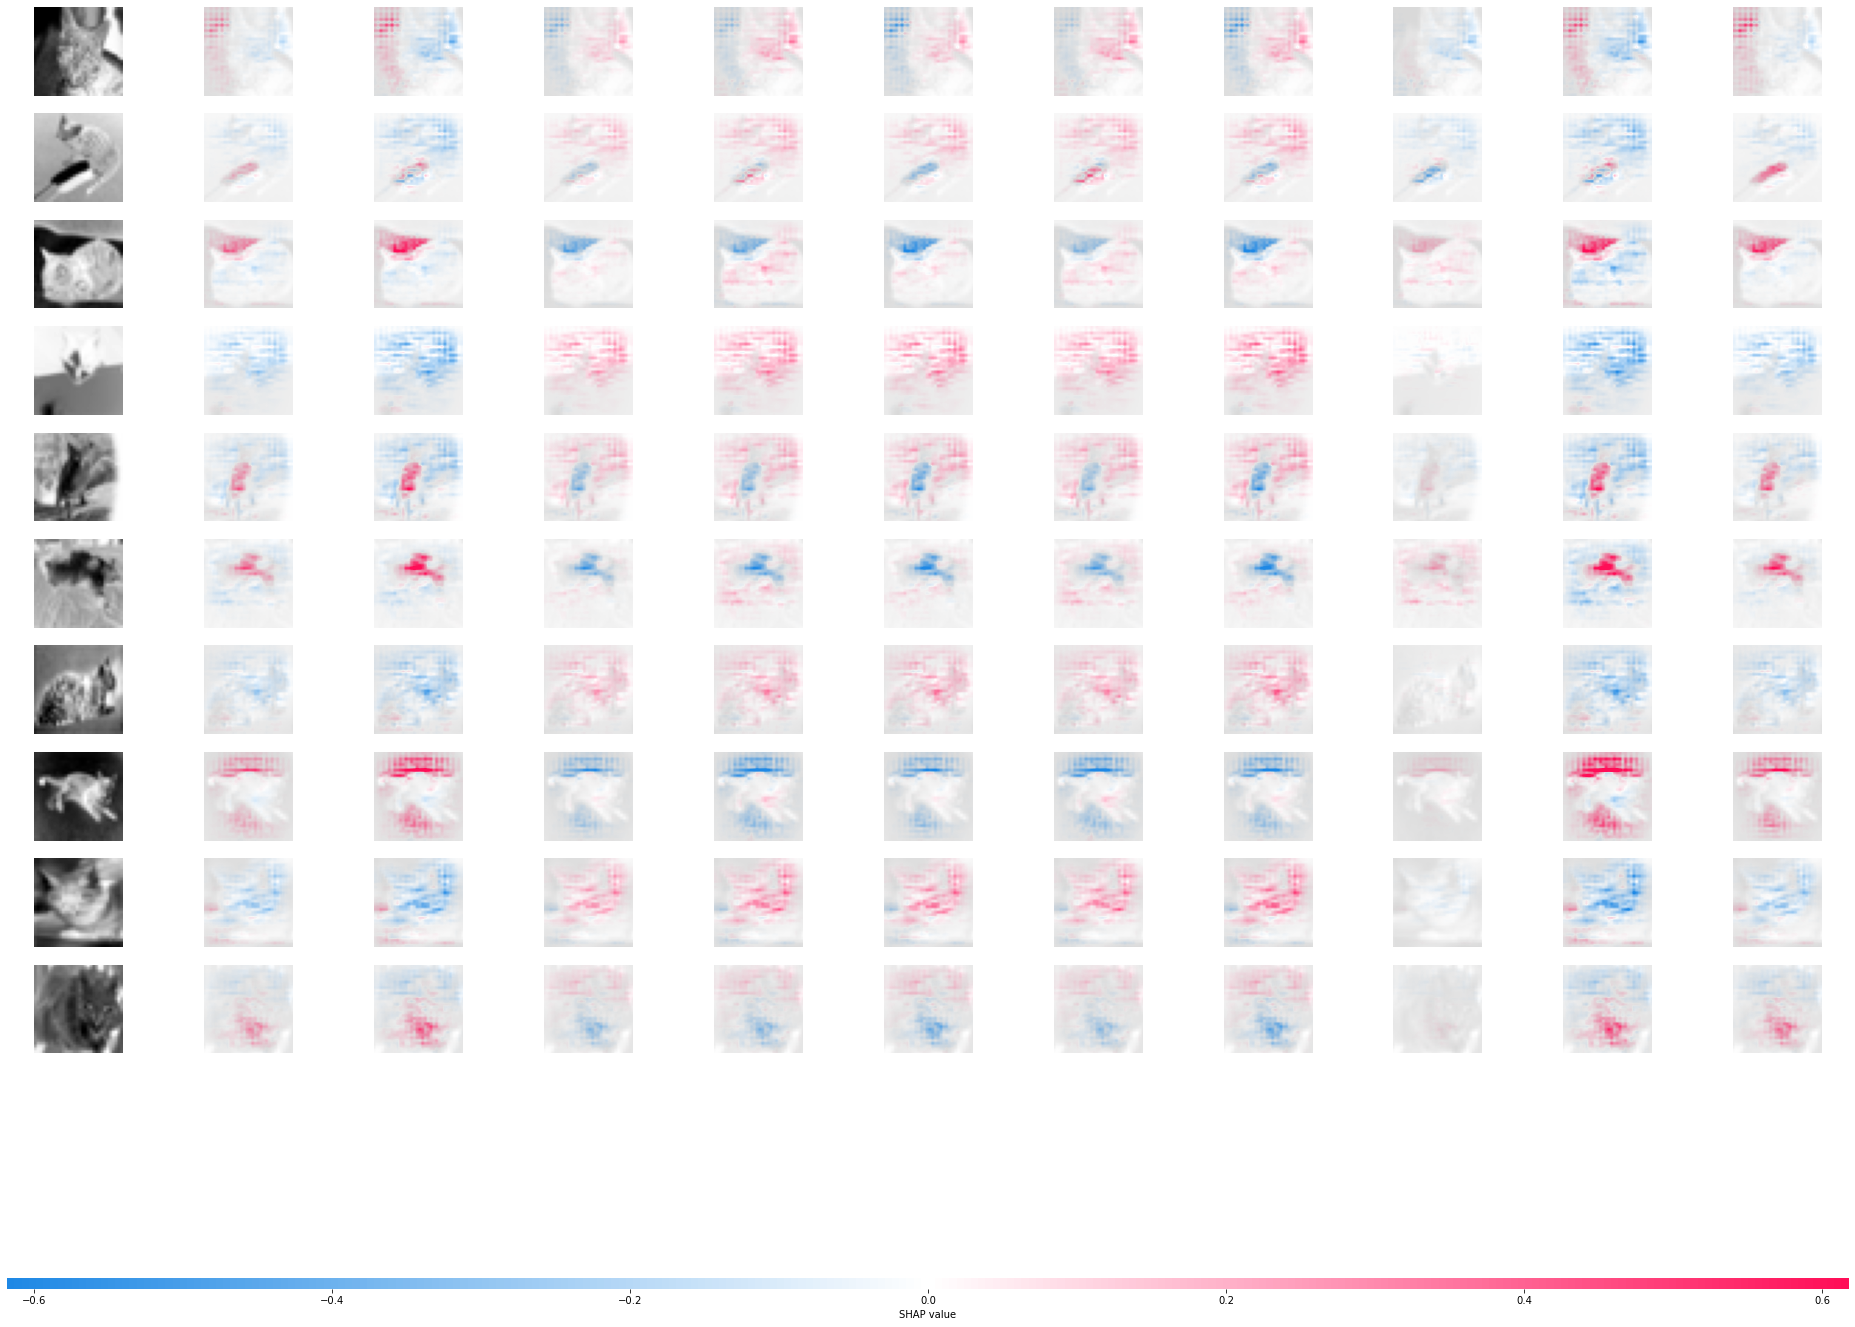

In [124]:
# shap on final layer output
# rows represent different image, columns represent the 10 different classes, and the corresponding features that highlight that class
net.eval()

batch = next(iter(testloader))
shap_train_imgs = batch[0][:10].to('cuda')
shap_test_imgs = batch[0][batch[1]==3][10:20].to('cuda') # choose the subset of images you're interested in

e = shap.DeepExplainer(net, shap_train_imgs)
shap_values = e.shap_values(shap_test_imgs)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(shap_test_imgs.cpu().numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy, width=100.0)
# plt.savefig('./shap_test.pdf') # add show=False argument to the shap.image_plot fn to save this plot